In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
path = "Entropy_Abhi_code\IK_50LMRD_entropy_C01_cropped.mpt"

data = pd.read_csv(path, sep="\t")
print(data.head())



   mode  ox/red  error  control changes  Ns changes  counter inc.  Ns  \
0     3       0      1                0           1             0   0   
1     3       0      0                0           0             0   0   
2     3       0      0                0           0             0   0   
3     3       0      0                0           0             0   0   
4     3       0      0                0           0             0   0   

   I Range  time/s  control/mA  ...  Capacitance discharge/�F  step time/s  \
0       39     0.0         0.0  ...                       0.0          0.0   
1       39     1.0         0.0  ...                       0.0          0.0   
2       39     2.0         0.0  ...                       0.0          0.0   
3       39     3.0         0.0  ...                       0.0          0.0   
4       39     4.0         0.0  ...                       0.0          0.0   

   Q discharge/mA.h  Q charge/mA.h  Capacity/mA.h  Efficiency/%  cycle number  \
0          

In [11]:
time = data["time/s"].to_numpy()
ewe = data["Ewe/V"].to_numpy()

In [4]:
# manually add to sys python path for pip import
#NOTE: Run this first in galvani folder pip install -e ".\`[tests`]"

import sys
import os

# Replace this with the actual path to your galvani directory
galvani_path = 'C:/Users/abhik/Code/ishi_electrochem/galvani'

# Add the path to sys.path if it's not already there
if galvani_path not in sys.path:
    sys.path.insert(0, galvani_path)

# Now try to import MPRfile
from galvani.BioLogic import MPRfile

# You can print sys.path to verify the addition
# print(sys.path)

version 0 col type [  0   1   0   2   0   3   0  21   0  31   0  65   0 131   0  39   0   4
   0  20   0   6   0   8   0   7   0  13   0  74   0 211   1 212   1 123
   0 124   0 125   0 126   0 182]
colID in flag_map 1 ('mode', 3, <class 'numpy.uint8'>)
colID in flag_map 2 ('ox/red', 4, <class 'numpy.bool_'>)
colID in flag_map 3 ('error', 8, <class 'numpy.bool_'>)
colID in flag_map 21 ('control changes', 16, <class 'numpy.bool_'>)
colID in flag_map 31 ('Ns changes', 32, <class 'numpy.bool_'>)
colID in flag_map 65 ('counter inc.', 128, <class 'numpy.bool_'>)
colID in dtype_map 131 ('Ns', '<u2')
colID in dtype_map 39 ('I Range', '<u2')
colID in dtype_map 4 ('time/s', '<f8')
colID in dtype_map 20 ('control/mA', '<f4')
colID in dtype_map 6 ('Ewe/V', '<f4')
colID in dtype_map 8 ('I/mA', '<f4')
colID in dtype_map 7 ('dq/mA.h', '<f8')
colID in dtype_map 13 ('(Q-Qo)/mA.h', '<f8')
colID in dtype_map 74 ('|Energy|/W.h', '<f8')
colID in dtype_map 211 ('Q charge/discharge/mA.h', '<f8')
colID in dt

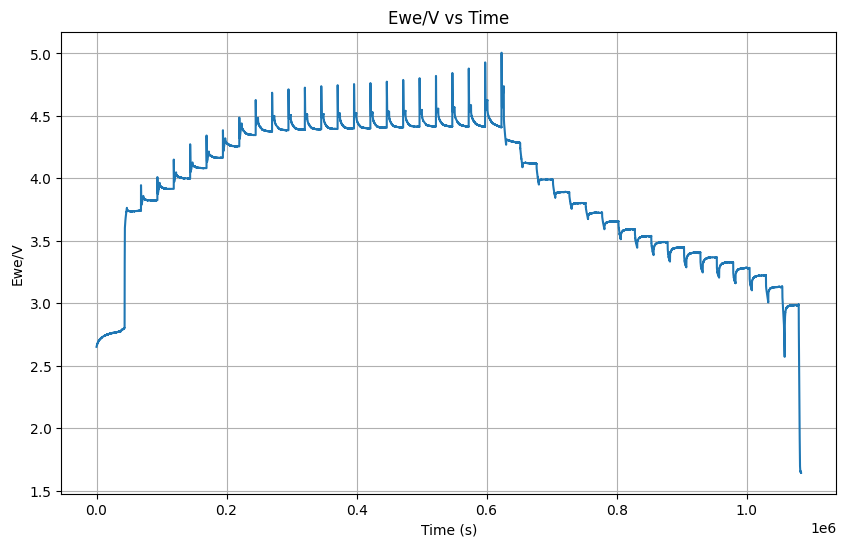

In [3]:
# Read the MPR file
file_path = 'Entropy_Abhi_code\IK_50LMRD_entropy_C01.mpr'  # Replace with your actual file path
mpr_file = MPRfile(file_path)

# Extract data
data = mpr_file.data

# Get Time and Ewe/V columns
time = data['time/s']
ewe = data['Ewe/V']
# print all columns
# Print all column names
print("All columns in the data:")
for column in data.dtype.names:
    print(column)
# capacity = data['Capacity/mA.h']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, ewe)
plt.xlabel('Time (s)')
plt.ylabel('Ewe/V')
plt.title('Ewe/V vs Time')
plt.grid(True)

# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('ewe_vs_time.png')

In [9]:
print(len(ewe))
print(len(time))
# print(len(capacity))

# Downsample ewe and time to give a reading every hour
ewe_hourly = ewe[::3600]
time_hourly = time[::3600]
# capacity_hourly = capacity[::3600]
time_hourly = time_hourly/3600
time_hourly = time_hourly.round()

print(len(ewe_hourly))
print(len(time_hourly))
print(time_hourly)

1083688
1083688
302
302
0            0.0
3600         1.0
7200         2.0
10800        3.0
14400        4.0
           ...  
1069200    297.0
1072800    298.0
1076400    299.0
1080000    300.0
1083600    301.0
Name: time/s, Length: 302, dtype: float64


In [ ]:
# Create a pandas dataframe that will outputted to a csv with the following headers:
# Time (h)	Peak  potential	Temperature	OCV	dE/dT	dS	Capacity (mAh)	Capacity corresponding to peak  potential (mAh/g)

# Create a dictionary with the data
times = []
peak_potential = []
temp = []
OCV = []
dE_dT = []
dS = []
capacity_peak_pot = []
mass = 0.0121884 # mass of the electrode in g
for v, t, c in zip(ewe_hourly, time_hourly, capacity_hourly):
    if t < 12: # ignore the first 12 hours
        continue
    if t %6==1:
        times.append(t)
        peak_potential.append(v)
        temp.append(' ')
        OCV.append(' ')
        capacity_peak_pot.append(c/mass)
        

        

data_dict = {
    'Time (h)': times,
    'Peak potential': peak_potential,
    'Temperature': temp,
    'OCV': OCV,
    'dE/dT': dE_dT,
    'dS': dS,
    'Capacity corresponding to peak  potential (mAh/g)': capacity_peak_pot
}


In [6]:
import yadg
import pandas as pd
import matplotlib.pyplot as plt
import json

# Path to your MPR file
file_path = 'Entropy_Abhi_code/IK_50LMRD_entropy_C01.mpt'
# yadg extract eclab.mpr example_file.mpr output_file.nc

# Extract data from the MPR file
# datagram = yadg.extractors.extract(filetype="eclab.mpr", path=file_path)
datagram = yadg.extractors.extract(filetype="eclab.mpt", path=file_path)

# Print the structure of the datagram (optional, for debugging)
print(json.dumps(datagram, indent=2))

# Convert the datagram to a pandas DataFrame
# Assuming the data is in the 'data' key of the datagram
df = pd.DataFrame(datagram['data'])

# Print column names
print("Columns in the data:")
print(df.columns)

# Print the first few

KeyError: 'Capacitance charge/ï¿½F'